This is an initial foray into the data provided, and is intended as a benchmark to build off of, with that said, lets begin by importing our data and relevant libraries to get a sense for how it is structured and what information we might be able to glean from it.

<img src="https://i.imgur.com/1jGXP8L.png" width="500px">

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.tree import DecisionTreeRegressor

train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
structures = pd.read_csv("../input/structures.csv")
print("Training Set")
print("Columns:" + str(train.columns))
print(train.head())
print()
print("Test Set")
print(test.head())
print()
print("Positional data for each molecule")
print(structures.head())

Training Set
Columns:Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant'],
      dtype='object')
   id           ...            scalar_coupling_constant
0   0           ...                             84.8076
1   1           ...                            -11.2570
2   2           ...                            -11.2548
3   3           ...                            -11.2543
4   4           ...                             84.8074

[5 rows x 6 columns]

Test Set
        id     molecule_name  atom_index_0  atom_index_1  type
0  4658147  dsgdb9nsd_000004             2             0  2JHC
1  4658148  dsgdb9nsd_000004             2             1  1JHC
2  4658149  dsgdb9nsd_000004             2             3  3JHH
3  4658150  dsgdb9nsd_000004             3             0  1JHC
4  4658151  dsgdb9nsd_000004             3             1  2JHC

Positional data for each molecule
      molecule_name  atom_index atom         x         y         z
0  

So it seems we have the molecules that the coupling pairs are in, the (x,y,z) position of each atom, the element of each atom in the molecule, and the coupling type, where the type encodes what atom the hydrogen is coupling to and through how many bonds. (e.g. type: 2JHC would mean that a hydrogen "H" has coupled through 2 bonds to a Carbon "C"). Unfortunately we have no information on the bonds within the molecules so we lose out on bond angles and bond types, however we can try and approximate the bond angles/types by counting the number of each element in each molecule (more hydrogens to carbons would indicate less double/triple bonds and vice versa). 

In [3]:
def merge_structural_data(df):
    df = pd.merge(left=df, right=structures, how="left", left_on=["molecule_name","atom_index_0"], right_on=["molecule_name","atom_index"])
    df = df.rename(index=str, columns={"x":"x_0", "y":"y_0", "z":"z_0"})
    df = pd.merge(left=df, right=structures, how="left",left_on=["molecule_name","atom_index_1"],right_on=["molecule_name","atom_index"])
    df = df.rename(index=str, columns={"x":"x_1", "y":"y_1", "z":"z_1","atom_x":"atom_0","atom_y":"atom_1"})
    df = df.drop(columns=["atom_index_x","atom_index_y"])
    return df

def euclid_dist(df):
    def dist(row):
        x_i = (row['x_0'] - row['x_1'])**2
        y_i = (row['y_0'] - row['y_1'])**2
        z_i = (row['z_0'] - row['z_1'])**2
        dist = (x_i + y_i + z_i)**0.5
        return dist
    df['distance'] = df.apply(lambda x: dist(x), axis=1)
    return df

def num_atoms(df):
    molecule_sizes = pd.DataFrame(structures['molecule_name'].value_counts()).rename(index=str, columns={"molecule_name":"atom_count"})
    molecule_sizes = molecule_sizes.sort_index()
    molecule_sizes['mol_name'] = molecule_sizes.index
    df = pd.merge(left=df, right=molecule_sizes, how="left", left_on="molecule_name", right_on="mol_name")
    df = df.drop(columns=["mol_name"])
    return df
    
def num_ele(df):
    for ele in structures['atom'].unique():
        ele_filtered = structures[structures['atom'] == ele]
        ele_num = pd.DataFrame(ele_filtered['molecule_name'].value_counts())
        ele_num = ele_num.rename(columns={'molecule_name':ele})
        ele_num['mol_nam'] = ele_num.index
        df = pd.merge(left=df, right=ele_num, how='left', left_on='molecule_name', right_on='mol_nam')
        df = df.fillna(0)
    return df

def type_dummies(df):
    df = pd.concat([df, pd.get_dummies(df['type'])], axis=1)
    return df

#This function was taken from: "https://www.kaggle.com/uberkinder/efficient-metric"
def group_mean_log_mae(y_true, y_pred, groups, floor=1e-9):
    maes = (y_true-y_pred).abs().groupby(groups).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

In [4]:
train = merge_structural_data(train)
test = merge_structural_data(test)

train = euclid_dist(train)
test = euclid_dist(test)

train = num_atoms(train)
test = num_atoms(test)

train = num_ele(train)
test = num_ele(test)

train = type_dummies(train)
test = type_dummies(test)

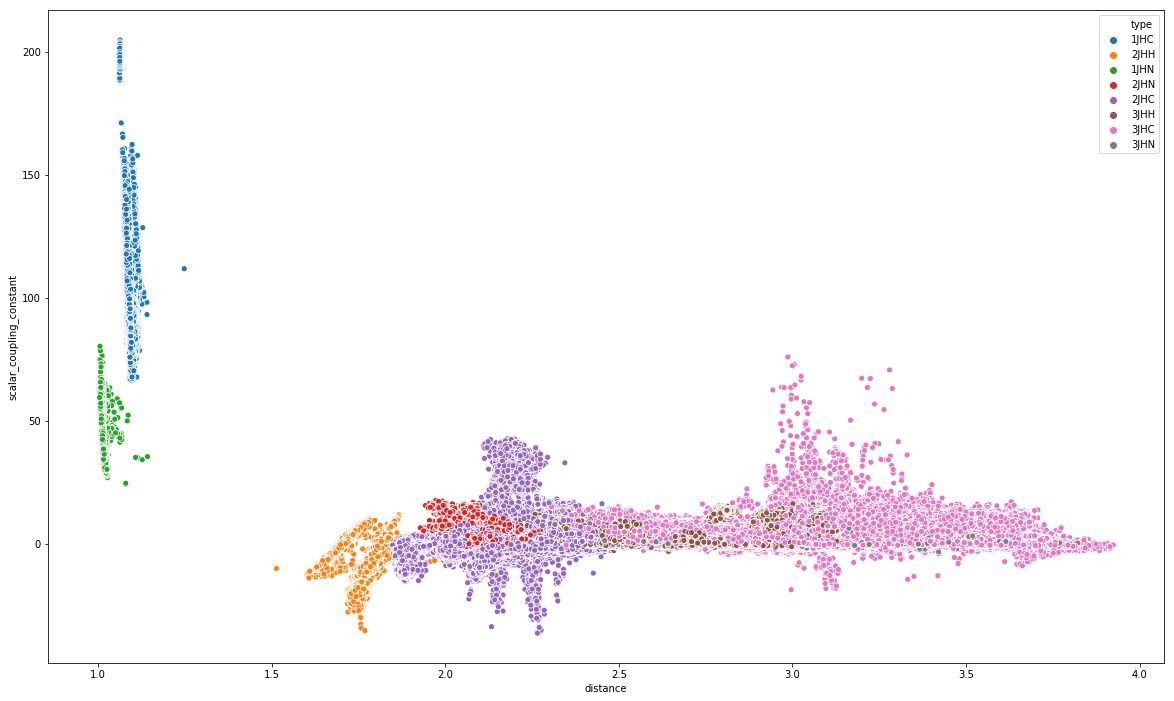

In [10]:
train_plot_data = train.loc[:,['distance','scalar_coupling_constant','type','atom_count']]
fig, ax = plt.subplots(figsize=(20,12))
sns.scatterplot(x='distance', y='scalar_coupling_constant', data=train_plot_data, hue='type')

TypeError: cannot label index with a null key

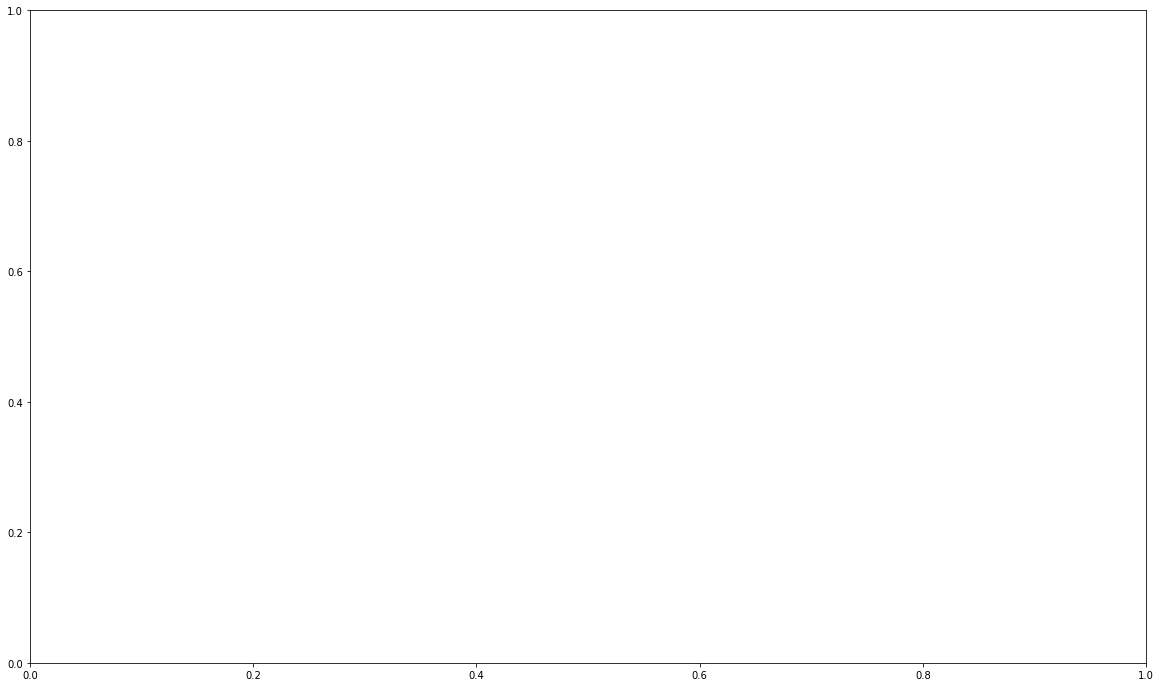

In [7]:
fig, ax = plt.subplots(figsize=(20,12))
sns.scatterplot(x='atom_count', y='scalar_coupling_constant', data=train_plot_data, hue='type')

We're just going to start off with a basic decision tree regression and then experiment with more sophisticated models in the future.

In [5]:
X_train = train.loc[:,['distance','x_0', 'y_0', 'z_0','x_1', 'y_1', 'z_1','atom_count','1JHC','1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN','H','C', 'N', 'O', 'F']]
y_train = train.loc[:,'scalar_coupling_constant']

X_test = test.loc[:,['distance','x_0', 'y_0', 'z_0','x_1', 'y_1', 'z_1','atom_count','1JHC','1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN', 'H','C', 'N', 'O', 'F']]

model = DecisionTreeRegressor(random_state = 0)
model.fit(X_train,y_train)

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

Lets look to see how well our model is fitting to the training data for each coupling type.

training error: -13.311199420373471


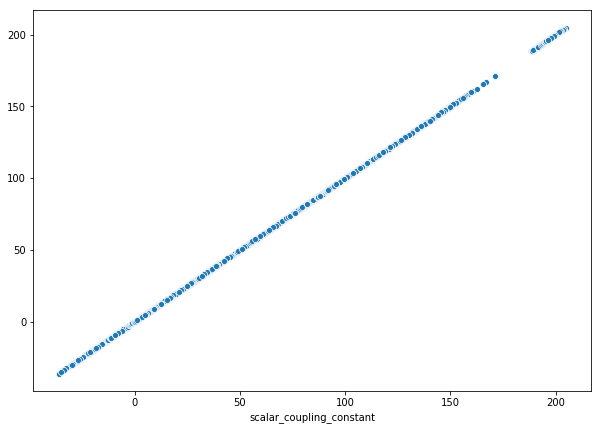

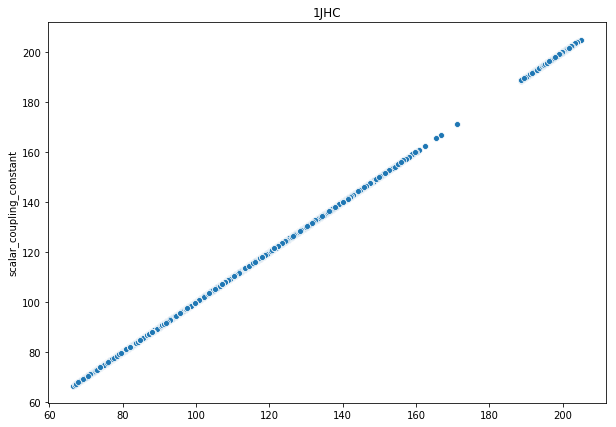

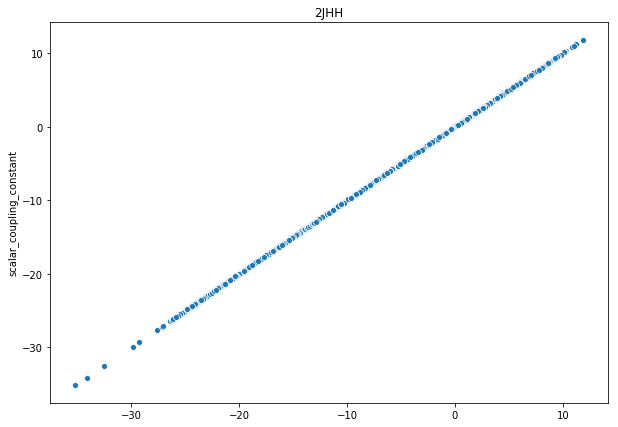

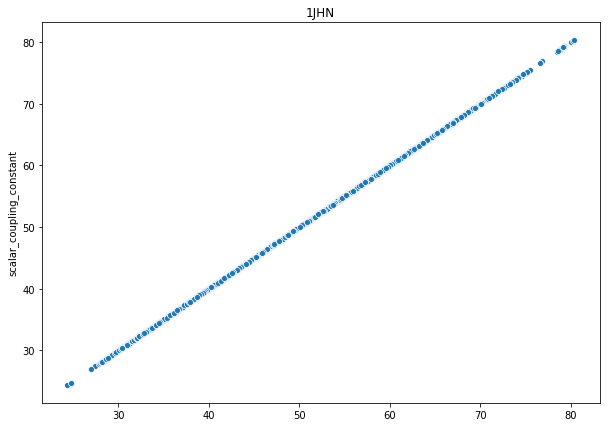

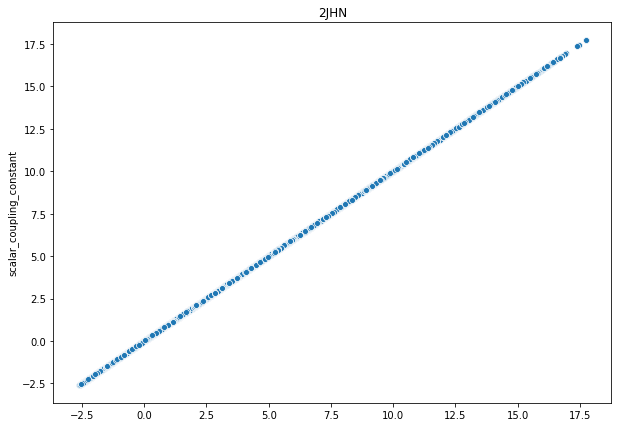

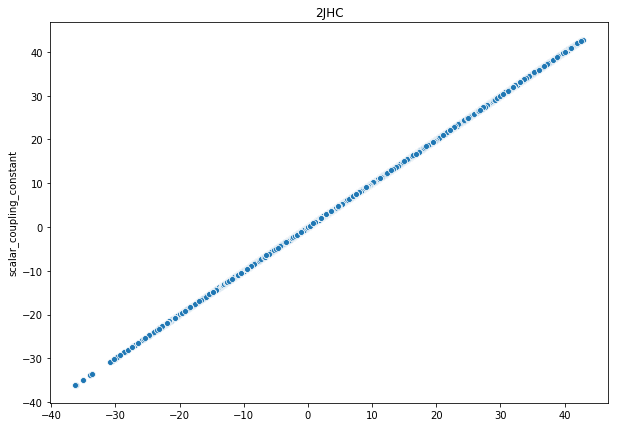

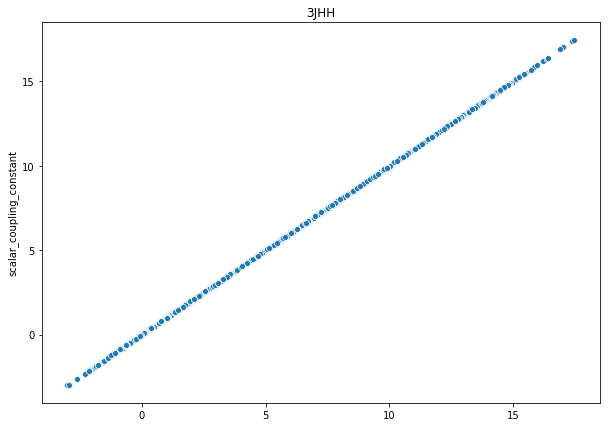

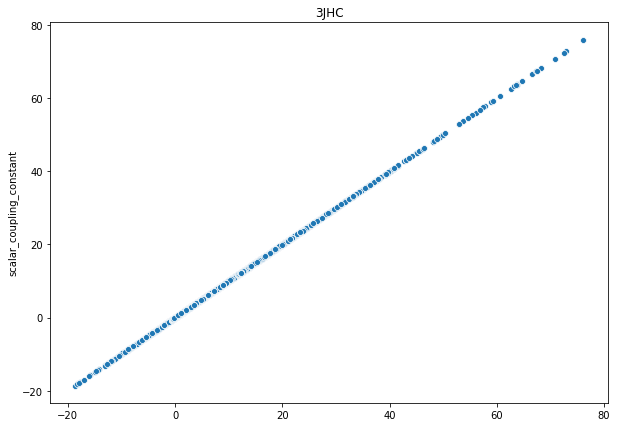

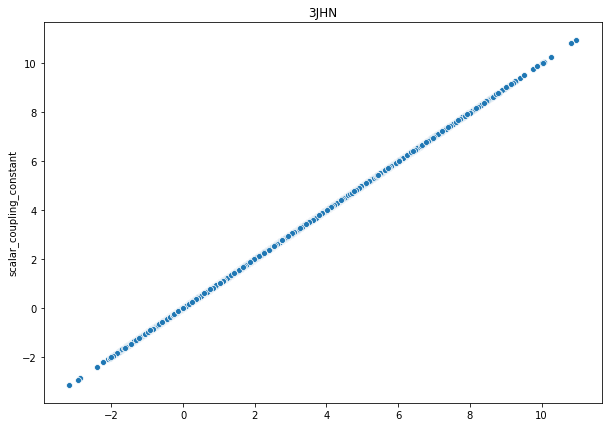

In [6]:
training_error = group_mean_log_mae(y_train,train_predictions,train['type'])
print("training error: " + str(training_error))

fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(y_train, train_predictions)

for coupl in train['type'].unique():
    fig, ax = plt.subplots(figsize=(10,7))
    sns.scatterplot(train_predictions[X_train[coupl] == 1], y_train[X_train[coupl] == 1])
    plt.title(coupl)
    plt.show()

Our model seems to fit quite well to the training set, it is most likely very overfit given the fact the training error is ~-13 and the best models on the leader board only achieved an error of ~-1.7

In [ ]:
test_predictions_df = pd.DataFrame(test_predictions)
test_predictions_df['id'] = test['id']
test_predictions_df['scalar_coupling_constant'] = test_predictions_df.iloc[:,0]
test_predictions_df = test_predictions_df.drop([0],axis=1)
print(test_predictions_df.columns)
print(test_predictions_df.shape)
test_predictions_df.to_csv("prediction_file.csv", index=False)

While this model does beat out the euclidean distance benchmark, it doesn't beat it by a lot and is very overfit, so we will need to construct more sophisticated descriptors for the molecules to feed into our model. These will descriptors will most likely need to better capture the aspects listed in scalar_coupling_contributions.csv, - more research is required. I will be updating this kernel as I come up with better features, let me know if there's anything obvious I have missed. :)